In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from random import shuffle

# Get the data

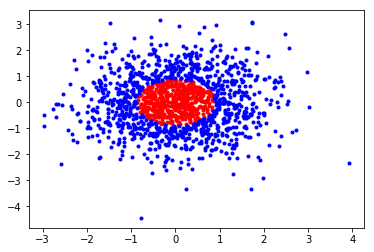

In [2]:
# number of features in
nfin   = 2
# number of classes
nClass = 2

X = torch.randn(2,1500)
R = torch.sqrt(X[0,:]**2 + X[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


C = torch.zeros(1500,dtype = torch.int64)
C[indRed]  = 0
C[indBlue] = 1

plt.plot(X.numpy()[0,indRed],X.numpy()[1,indRed],'.r')
plt.plot(X.numpy()[0,indBlue],X.numpy()[1,indBlue],'.b')


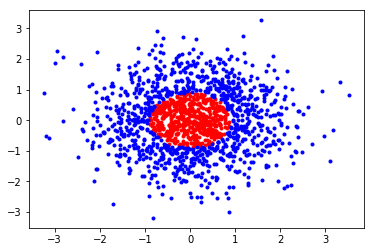

In [3]:
# Get a validation set
XVal = torch.randn(2,1500)
R = torch.sqrt(XVal[0,:]**2 + XVal[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


CVal = torch.zeros(1500,dtype = torch.int64)
CVal[indRed]  = 0
CVal[indBlue] = 1

plt.plot(XVal.numpy()[0,indRed],XVal.numpy()[1,indRed],'.r')
plt.plot(XVal.numpy()[0,indBlue],XVal.numpy()[1,indBlue],'.b')

# Design the simples NN

In [4]:
lossFunc = nn.CrossEntropyLoss()

def misfit(X,W,bias,C):
    n = W.shape
    X = X.view(n[1],-1)
    S = torch.matmul(W,X) 
    S += bias.unsqueeze(1)
    return lossFunc(S.t(),C)

In [19]:
class singleLayerNet(nn.Module):

    def __init__(self,NetGeo):
        super().__init__()
        self.NetGeo = NetGeo
        
    def forward(self,x,K,b):
        # make sure we arrange x correctly (data in columns)
        z = torch.matmul(K,x)
        y = F.relu(z+b)
        return y 


# Initialize all parameter

In [27]:
nfout = 20
NG    = [nfin,nfout]
net   = singleLayerNet(NG)

# weights for linear classifier    
W      = nn.Parameter(torch.randn(nClass,nfout)*1e-3,requires_grad=True)
bW     = nn.Parameter(torch.randn(nClass)*1e-2,requires_grad=True)
# weights for the NN    
K      = nn.Parameter(torch.randn(nfout,nfin)*1e-3,requires_grad=True)
b      = nn.Parameter(torch.randn(1)*1e-2,requires_grad=True)

nparout = np.prod(W.shape) + np.prod(bW.shape) + np.prod(K.shape) + 1

print('Total number of parameter',nparout)
print('Total number of data',C.shape[0])

Total number of parameter 83
Total number of data 1500


In [21]:
# run the network
x = net(X,K,b)
label = C
loss = misfit(x,W,bW,label)
print('Initial loss = ', loss.detach().numpy())    
print('Sanity Check = ',np.log(2.0))

Initial loss =  0.6931194
Sanity Check =  0.6931471805599453


In [22]:
# Check derivatives
loss.backward()
print(bW.grad)
print(torch.norm(W.grad))
print(torch.norm(K.grad))
print(torch.norm(b.grad))



tensor([ 0.1546, -0.1546])
tensor(1.00000e-04 *
       1.0110)
tensor(1.00000e-04 *
       1.0587)
tensor(1.00000e-05 *
       7.6285)


In [23]:
import torch.optim as optim
optimizer = optim.SGD([{'params': W},{'params': K},{'params': bW},{'params': b}], lr = 1e-2,momentum=0.0)

In [24]:
for epoch in range(100):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    for i in range(X.shape[1]):
        
        optimizer.zero_grad()
        # get the inputs
        inputs = X[:,i:i+1]
        labels = C[i:i+1]

        # forward 
        x      = net(inputs,K,b)
        lossi = misfit(x,W,bW,labels)
        if i==0:
            loss = lossi
        else:
            loss  += lossi
            
        lossi.backward()
        optimizer.step()
        g += torch.norm(W.grad) + torch.norm(bW.grad) + torch.norm(K.grad) + torch.norm(b.grad)    
     
    print('%d  %.3f   %.3f'% (epoch+1, loss, g))

print('Finished Training')

1  974.217   977.375
2  968.956   960.488
3  968.942   979.491
4  968.626   1069.192
5  962.261   1440.185
6  882.534   2411.809
7  641.661   3032.350
8  433.017   2819.531
9  329.095   2534.585
10  274.091   2341.316
11  239.803   2200.197
12  215.721   2091.109
13  197.522   1998.027
14  183.506   1927.714
15  171.691   1860.664
16  161.874   1802.226
17  153.280   1747.582
18  145.869   1698.839
19  139.158   1654.705
20  132.951   1599.076
21  126.991   1552.942
22  121.933   1510.412
23  117.626   1478.393
24  113.407   1444.721
25  109.618   1415.677
26  106.206   1384.566
27  103.082   1361.415
28  100.043   1329.675
29  97.258   1300.611
30  94.718   1274.314
31  92.378   1253.744
32  90.393   1233.192
33  88.586   1220.884
34  87.131   1207.530
35  85.752   1199.087
36  84.414   1189.485
37  83.078   1183.728
38  81.940   1171.788
39  80.785   1164.599
40  79.758   1155.731
41  78.696   1149.606
42  77.827   1140.999
43  76.903   1134.264
44  76.047   1125.374
45  75.251   111

# Plot the results on validation

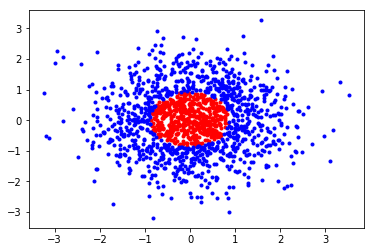

In [25]:
x      = net(XVal,K,b)
S      = torch.matmul(W,x)
S     += bW.unsqueeze(1)
_,Cpred = torch.max(S,dim=0)


indRed   = (Cpred==0).nonzero()
indBlue  = (Cpred==1).nonzero()


plt.plot(XVal[0,indRed].numpy(),XVal[1,indRed].numpy(),'.r')
plt.plot(XVal[0,indBlue].numpy(),XVal[1,indBlue].numpy(),'.b')
